# Train a domain classifier on the [semantic scholar dataset](https://api.semanticscholar.org/corpus)

> Part 3: Create production inference function

![position of this step in the lifecycle](diagrams/scope-deploy.svg)
> The blue boxes show the steps implemented in this notebook.

In [Part 2](train.ipynb), we trained our AI model. Now, it's time to create **G**eneral **R**obust **E**nd-to-end **A**utomated **T**rustworthy deployment from it using the `GreatAI` Python package.

In [1]:
import re
from sklearn.pipeline import Pipeline
from great_ai.utilities import clean
from great_ai import (
    MultiLabelClassificationOutput,
    ClassificationOutput,
    GreatAI,
    use_model,
    parameter,
)


@GreatAI.deploy
@use_model("small-domain-prediction", version="latest")
@parameter("explanation_length", disable_logging=True)
def predict_domain(
    text: str, model: Pipeline, target_confidence: int = 50, explanation_length: int = 5
) -> MultiLabelClassificationOutput:
    """
    Predict the scientific domain of the input text.
    Return labels until their sum likelihood is larger than `target_confidence`.
    """
    assert 0 <= target_confidence <= 100, "invalid argument"

    preprocessed = re.sub(r"[^a-zA-Z\s]", "", clean(text, convert_to_ascii=True))
    features = model.named_steps["vectorizer"].transform([preprocessed])
    prediction = model.named_steps["classifier"].predict_proba(features)[0]

    best_classes = sorted(enumerate(prediction), key=lambda v: v[1], reverse=True)

    results = MultiLabelClassificationOutput()
    for class_index, probability in best_classes:
        results.labels.append(
            ClassificationOutput(
                label=model.named_steps["classifier"].classes_[class_index],
                confidence=round(probability * 100),
                explanation=[
                    word
                    for _, word in sorted(
                        (
                            (weight, word)
                            for weight, word, count in zip(
                                model.named_steps["classifier"].feature_log_prob_[
                                    class_index
                                ],
                                model.named_steps["vectorizer"].get_feature_names_out(),
                                features.A[0],
                            )
                            if count > 0
                        ),
                        reverse=True,
                    )
                ][:explanation_length],
            )
        )

        if sum(r.confidence for r in results.labels) >= target_confidence:
            break

    return results

2022-06-19 15:16:23,856 |  WARNING | Environment variable ENVIRONMENT is not set, defaulting to development mode ‼️
2022-06-19 15:16:23,857 |  WARNING | The selected tracing database (ParallelTinyDbDriver) is not recommended for production
2022-06-19 15:16:23,858 |     INFO | Options: configured ✅
2022-06-19 15:16:23,858 |     INFO | Fetching cached versions of small-domain-prediction
2022-06-19 15:16:23,859 |     INFO | Latest version of small-domain-prediction is 12 (from versions: 9, 10, 11, 12)
2022-06-19 15:16:23,860 |     INFO | File small-domain-prediction-12 found in cache


## Check accuracy on the test split

2022-06-19 15:16:29,300 |  WARNING | Limiting concurrency to 10 because there are only 10 chunks
2022-06-19 15:16:29,301 |     INFO | Starting parallel map (concurrency: 10, chunk size: 1)


  0%|          | 0/10 [00:00<?, ?it/s]

/data/projects/great-ai/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/projects/great-ai/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/projects/great-ai/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/projects/gre

                   precision    recall  f1-score   support

          Biology       1.00      1.00      1.00         1
 Computer Science       1.00      0.67      0.80         3
Materials Science       0.00      0.00      0.00         1
      Mathematics       0.00      0.00      0.00         0
         Medicine       1.00      1.00      1.00         3
          Physics       0.50      1.00      0.67         1
       Psychology       1.00      1.00      1.00         1

         accuracy                           0.80        10
        macro avg       0.64      0.67      0.64        10
     weighted avg       0.85      0.80      0.81        10



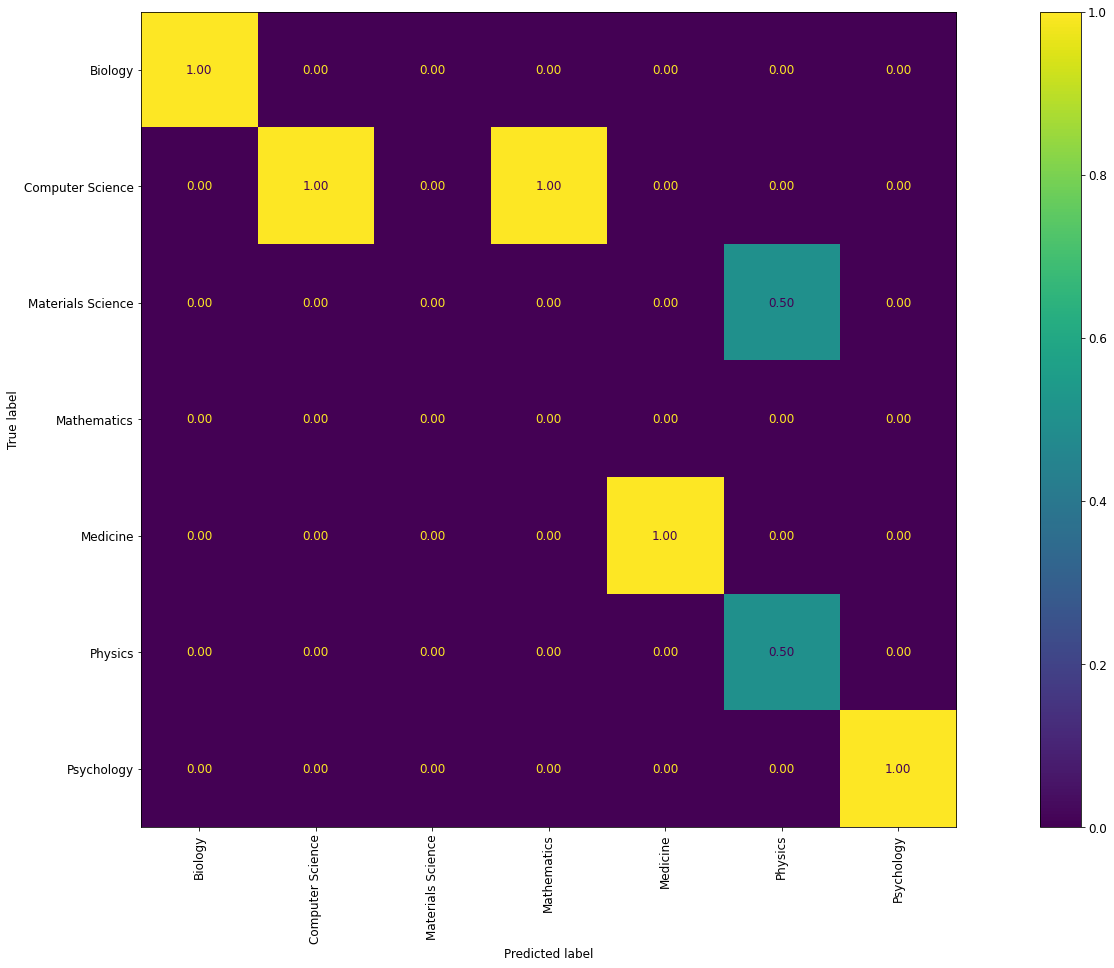

In [3]:
if __name__ == "__main__":
    from great_ai import query_ground_truth
    from sklearn import metrics

    data = query_ground_truth("test", return_max_count=10)

    X = [d.input for d in data]
    y_actual = [d.feedback for d in data]

    y_predicted = [d.output.labels[0].label for d in predict_domain.process_batch(X)]
    y_actual_aligned = [p if p in a else a[0] for p, a in zip(y_predicted, y_actual)]

    import matplotlib.pyplot as plt

    # Configure matplotlib to have nice, high-resolution charts.

    %matplotlib inline

    plt.rcParams["figure.figsize"] = (30, 15)
    plt.rcParams["figure.facecolor"] = "white"
    plt.rcParams["font.size"] = 12
    plt.rcParams["axes.xmargin"] = 0

    print(metrics.classification_report(y_actual_aligned, y_predicted))
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_true=y_actual_aligned,
        y_pred=y_predicted,
        xticks_rotation="vertical",
        normalize="pred",
        values_format=".2f",
    )